## A/B Test for continuous target variable

### Setup

In [1]:
%matplotlib inline

import pandas as pd
import pymc3  as pm
import numpy  as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from scipy import stats

### Data

In [2]:
df_data = pd.read_csv('test_daten_ab.csv', delimiter=';', header=None, names=["group", "value"])

In [3]:
y_A = pd.to_numeric(df_data[df_data.group == 1]['value'].str.replace(',', '.'))
y_B = pd.to_numeric(df_data[df_data.group == 2]['value'].str.replace(',', '.'))

In [4]:
y_A = y_A[y_A < 3000]

### Inference statistics

In [5]:
y_A.mean()

32.89227504851148

In [6]:
y_B.mean()

32.36946860001071

In [7]:
stats.ttest_ind(y_A, y_B)

Ttest_indResult(statistic=2.2704571751122726, pvalue=0.023180211753631979)

In [8]:
stats.mannwhitneyu(y_A, y_B)

MannwhitneyuResult(statistic=44887758488.5, pvalue=0.010815439835386175)

RESULT: The mean value associated with layout A is significantly bigger than in case of layout B (p < 0.05).

### Bayesian statistics

#### Gamma distribution.

In [9]:
with pm.Model() as model:
    
    # Initial, prior distributions of unknown, latent variables of the model.
    alpha_A = pm.Uniform('alpha_A', lower=0.5, upper=3)
    beta_A  = pm.Uniform('beta_A' , lower=1,   upper=5)
    
    alpha_B = pm.Uniform('alpha_B', lower=0.5, upper=3)
    beta_B  = pm.Uniform('beta_B' , lower=1,   upper=5)
    
    amount_A = pm.Gamma('amount_A', alpha=alpha_A, beta=beta_A)
    amount_B = pm.Gamma('amount_B', alpha=alpha_B, beta=beta_B)
    
    delta = pm.Deterministic('delta', amount_A - amount_B)

In [10]:
with model:
    
    # Likelihood modeling of observations.
    obs_A = pm.Gamma("obs_A", alpha=alpha_A, beta=beta_A, observed=y_A)
    obs_B = pm.Gamma("obs_B", alpha=alpha_B, beta=beta_B, observed=y_B)

In [11]:
with model:

    # Sample from posterior distributions.
    step = pm.Metropolis()
    trace = pm.sample(3000, step=step)

100%|██████████| 3500/3500 [00:55<00:00, 62.97it/s]


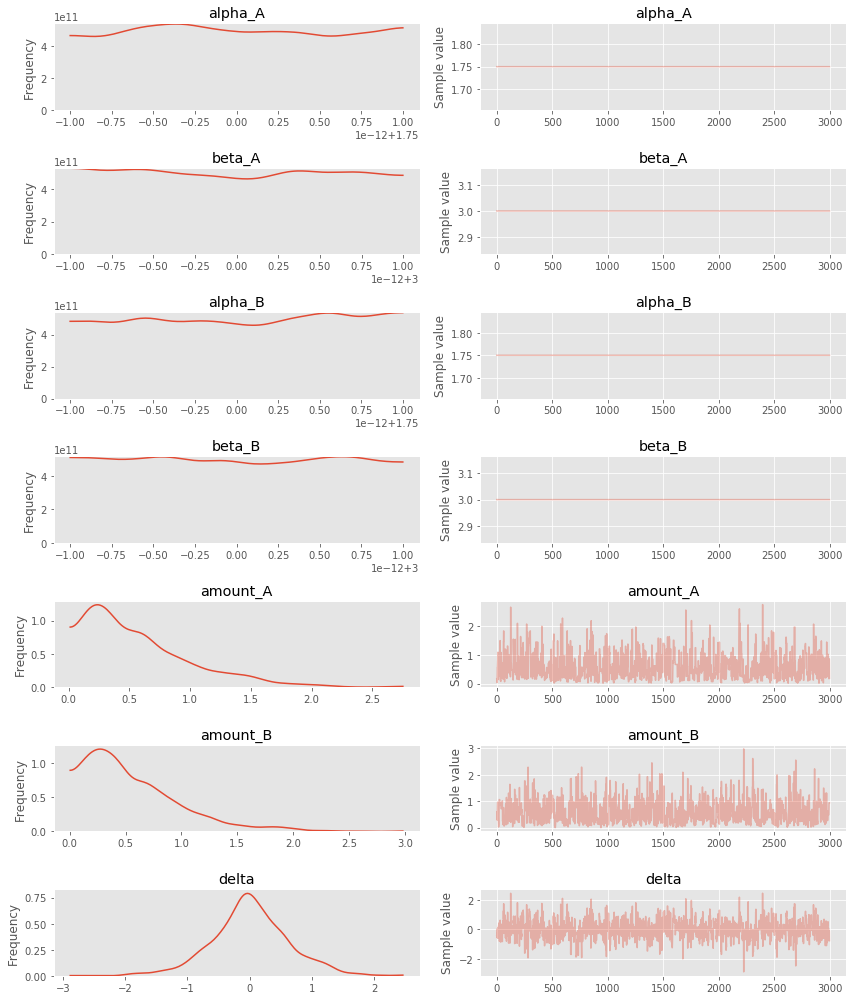

In [12]:
_ = pm.traceplot(trace)

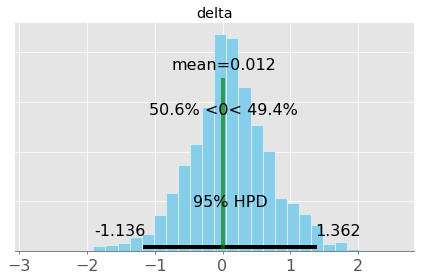

In [13]:
_ = pm.plot_posterior(trace, varnames=['delta'], ref_val=0, color='#87ceeb')

RESULT: Layout A is better than layout B with a probability of 49%.

#### Wald log-likelihood distribution

In [14]:
with pm.Model() as model:
    
    # Initial, prior distributions of unknown, latent variables of the model.
    mu_A     = pm.Uniform('mu_A',     lower=0, upper=5)
    lambda_A = pm.Uniform('lambda_A', lower=0, upper=5)
    
    mu_B     = pm.Uniform('mu_B',     lower=0, upper=5)
    lambda_B = pm.Uniform('lambda_B', lower=0, upper=5)
    
    amount_A = pm.Wald('amount_A', mu=mu_A, lam=lambda_A)
    amount_B = pm.Wald('amount_B', mu=mu_B, lam=lambda_B)
    
    delta = pm.Deterministic('delta', amount_A - amount_B)

In [15]:
with model:
    
    # Likelihood modeling of observations.
    obs_A = pm.Wald("obs_A", mu=mu_A, lam=lambda_A, observed=y_A)
    obs_B = pm.Wald("obs_B", mu=mu_B, lam=lambda_B, observed=y_B)

In [16]:
with model:

    # Sample from posterior distributions.
    step = pm.Metropolis()
    trace = pm.sample(3000, step=step)

100%|██████████| 3500/3500 [01:19<00:00, 44.03it/s]


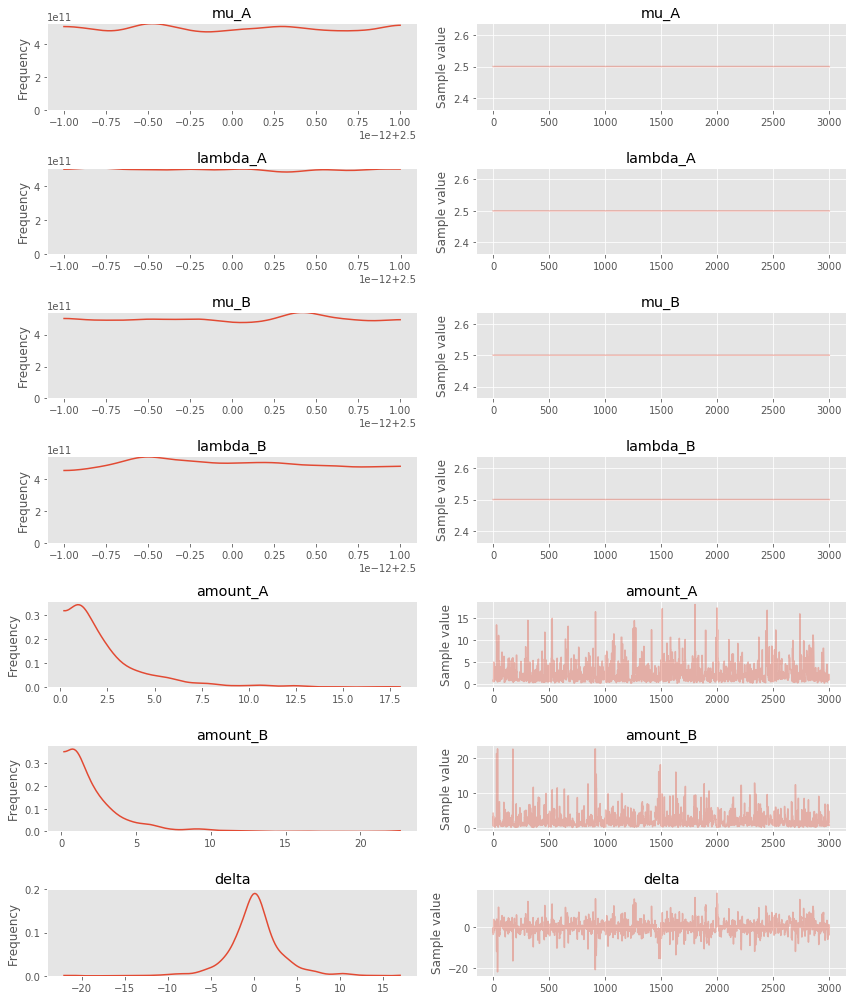

In [17]:
_ = pm.traceplot(trace)

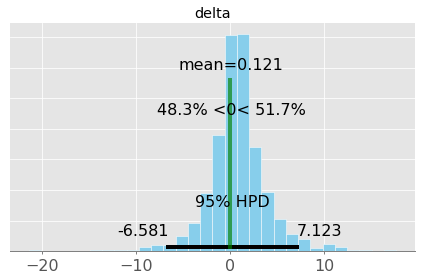

In [18]:
_ = pm.plot_posterior(trace, varnames=['delta'], ref_val=0, color='#87ceeb')

#### Half-Cauchy log-likelihood

In [19]:
with pm.Model() as model:
    
    # Initial, prior distributions of unknown, latent variables of the model.
    beta_A = pm.Uniform('beta_A', lower=0, upper=5)
    beta_B = pm.Uniform('beta_B', lower=0, upper=5)
    
    amount_A = pm.HalfCauchy('amount_A', beta=beta_A)
    amount_B = pm.HalfCauchy('amount_B', beta=beta_B)
    
    delta = pm.Deterministic('delta', amount_A - amount_B)

In [20]:
with model:
    
    # Likelihood modeling of observations.
    obs_A = pm.HalfCauchy("obs_A", beta=beta_A, observed=y_A)
    obs_B = pm.HalfCauchy("obs_B", beta=beta_B, observed=y_B)

In [21]:
with model:

    # Sample from posterior distributions.
    step = pm.Metropolis()
    trace = pm.sample(3000, step=step)

100%|██████████| 3500/3500 [01:10<00:00, 49.49it/s]


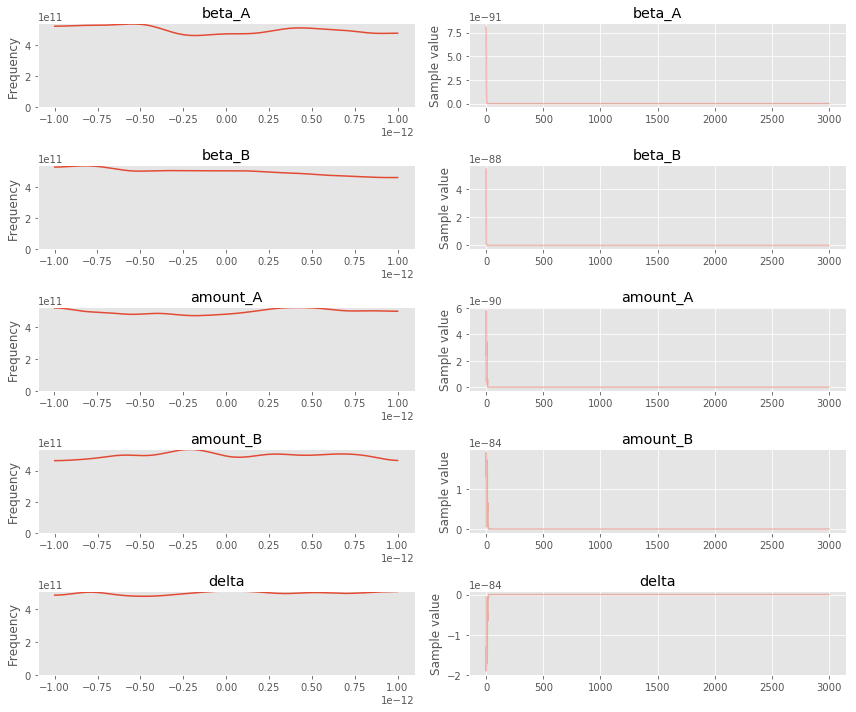

In [22]:
_ = pm.traceplot(trace)

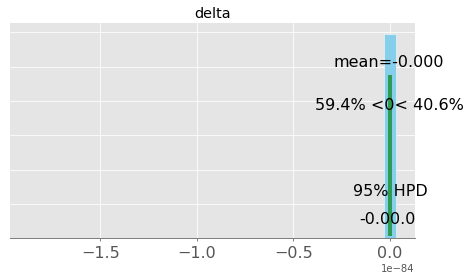

In [23]:
_ = pm.plot_posterior(trace, varnames=['delta'], ref_val=0, color='#87ceeb')

### Bootstrapping

In [24]:
delta = pd.DataFrame()

In [25]:
delta['values'] = [(y_A.sample(1000).mean() - y_B.sample(1000).mean()) for i in range(5000)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11bbd0eb8>]], dtype=object)

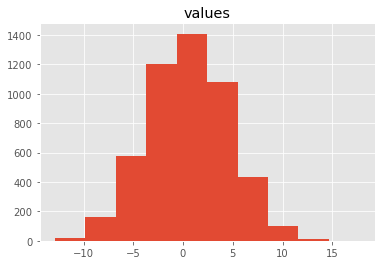

In [26]:
delta.hist()

With a probability of 95%The probability that the mean is between the following values:

In [27]:
delta.quantile(q=[0.025, 0.975], axis=0)

,values
0.025,-7.436444
0.975,8.394255


The mean is between these two values with a probability of 95%.